## Machine Learning Final Project
- [Tabular Playground Series August 2022](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/overview)

### Import Modules

In [235]:
! pip install -q feature-engine

In [236]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, HuberRegressor
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from feature_engine.encoding import WoEEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt

#### Download Data Using Kaggle API

In [237]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c tabular-playground-series-aug-2022
# ! mkdir train
# ! unzip tabular-playground-series-aug-2022.zip -d train

### Preprocess the Data

In [238]:
train = pd.read_csv("train/train.csv")
test = pd.read_csv("train/test.csv")

data = pd.concat([train, test])

### Feature Engineering

- reference to [TPSAUG22 EDA which makes sense](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense#The-float-columns)
- new features: m3_missing, m5_missing, area(attri_2*attri_3), average, standard deviation of m3 to m16
- original features: loading, measurement_17

In [239]:
# new features
data["m3_missing"] = data["measurement_3"].isnull().astype(np.int8)
data["m5_missing"] = data["measurement_5"].isnull().astype(np.int8)
data["area"] = data["attribute_2"] * data["attribute_3"]
label = [f"measurement_{i:d}" for i in range(3, 17)]


# modify features
data["loading"] = np.log(data["loading"])

#### Imputing

- Mostly KNN
- HuberRegression on measurement_17

In [240]:
ref_dict = {
    "A": ["measurement_5", "measurement_6", "measurement_8"],
    "B": ["measurement_4", "measurement_5", "measurement_7"],
    "C": ["measurement_5", "measurement_7", "measurement_8", "measurement_9"],
    "D": ["measurement_5", "measurement_6", "measurement_7", "measurement_8"],
    "E": ["measurement_4", "measurement_5", "measurement_6", "measurement_8"],
    "F": ["measurement_4", "measurement_5", "measurement_6", "measurement_7"],
    "G": ["measurement_4", "measurement_6", "measurement_8", "measurement_9"],
    "H": [
        "measurement_4",
        "measurement_5",
        "measurement_7",
        "measurement_8",
        "measurement_9",
    ],
    "I": ["measurement_3", "measurement_7", "measurement_8"],
}
print(type(data))
features = [
    feature
    for feature in test.columns
    if feature.startswith("measurement") or feature == "loading"
]

<class 'pandas.core.frame.DataFrame'>


In [241]:
for code in data.product_code.unique():
    cur_data = data[data.product_code == code]
    cur_ref = ref_dict[code]

    train_x = cur_data[cur_ref + ["measurement_17"]].dropna(how="any")

    test_x = cur_data[
        (cur_data[cur_ref].isnull().sum(axis=1) == 0)
        & (cur_data["measurement_17"].isnull())
    ]

    model = HuberRegressor(epsilon=1.9)
    model.fit(train_x[cur_ref], train_x["measurement_17"])

    data.loc[
        (data.product_code == code)
        & (data[cur_ref].isnull().sum(axis=1) == 0)
        & (data["measurement_17"].isnull()),
        "measurement_17",
    ] = model.predict(test_x[cur_ref])

    knn = KNNImputer(n_neighbors=3)
    data.loc[data.product_code == code, features] = knn.fit_transform(
        data.loc[data.product_code == code, features]
    )

#### Scaling

In [242]:
def scaling(train, valid, test, features):
    scaler = StandardScaler()
    # fit the scaler
    scaled_train = scaler.fit_transform(train[features])
    scaled_val = scaler.transform(valid[features])
    scaled_test = scaler.transform(test[features])

    # copy a new one
    new_train = train.copy()
    new_val = valid.copy()
    new_test = test.copy()

    new_train[features] = scaled_train
    new_val[features] = scaled_val
    new_test[features] = scaled_test

    return new_train, new_val, new_test

### Training Function

- Cross Validation


In [243]:
# try different features
feature_used = [
    "loading",
    "attribute_0",
    "area",
    "measurement_17",
    "m3_missing",
    "m5_missing",
    "measurement_0",
    "measurement_1",
    "measurement_2",
]

In [244]:
train = data[data["failure"].notnull()]
test = data[data["failure"].isnull()].drop(["failure"], axis=1)

x = train.drop(["failure"], axis=1)
y = train["failure"].astype(int)

- Encode attribute_0 with weight of evidence encoder

In [245]:
woe_encoder = WoEEncoder(variables=["attribute_0"])
woe_encoder.fit(x, y)

x = woe_encoder.transform(x)
test = woe_encoder.transform(test)

In [246]:
def regression(model, features, idx):
    final_result = np.zeros(len(test))
    avg_auc = 0
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    feature_importance = []
    for i, (train_idx, valid_idx) in enumerate(kf.split(x, y)):
        x_train = x.iloc[train_idx]
        y_train = y.iloc[train_idx]

        x_val = x.iloc[valid_idx]
        y_val = y.iloc[valid_idx]

        x_train, x_val, x_test = scaling(x_train, x_val, test, features)

        model.fit(x_train[features], y_train)
        feature_importance.append(model.coef_.ravel())
        val_pred = model.predict_proba(x_val[features])[:, 1]
        print(f"FOLD {i+1} auc_score: {roc_auc_score(y_val, val_pred):.3f}")
        avg_auc += roc_auc_score(y_val, val_pred) / 5
    final_result += model.predict_proba(x_test[features])[:, 1]

    feature_importance = np.array(feature_importance)
    sorted_arg = np.argsort(np.abs(feature_importance.mean(axis=0)))[::-1]
    features = np.array(features)
    sorted_feature = features[sorted_arg]
    plt.barh(
        y=np.linspace(10, 0, len(features)),
        width=np.abs(feature_importance.mean(axis=0))[sorted_arg],
        height=1,
        color="skyblue",
    )
    plt.yticks(ticks=np.linspace(10, 0, len(features)), labels=sorted_feature)
    plt.title("Feature importances")
    plt.show()
    # plt.savefig(f"{idx}.png")

    print(f"AVG auc_score: {avg_auc}")

    return final_result

### Ensemble Methods


#### Grid Search Experiments

In [247]:
# # Grid Search
# parameters = {
#     "max_iter":[200, 300, 400, 500, 600, 700, 800],
#     "C": [0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
# }

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
# grid_model = GridSearchCV(LogisticRegression(max_iter=200, C=0.05, penalty='l1', solver='liblinear'), scoring='roc_auc', param_grid=parameters, cv=skf)
# grid_model.fit(x[features], y)

# print(f"best param: {grid_model.best_params_}")
# print(f"best score: {grid_model.best_score_}")

In [248]:
# # Grid Search
# parameters = {
#     "max_iter":[500, 1000, 1500, 2000, 2500],
#     "C": [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
# }

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
# grid_model = GridSearchCV(LogisticRegression(max_iter=200, C=0.05, penalty='l2', solver='newton-cg'), scoring='roc_auc', param_grid=parameters, cv=skf)
# grid_model.fit(x[features], y)

# print(f"best param: {grid_model.best_params_}")
# print(f"best score: {grid_model.best_score_}")

In [249]:
# # Grid Search
# parameters = {
#     "max_iter":[1000, 2000, 2500, 3000, 3500, 4000],
#     "C": [0.001, 0.005, 0.007, 0.01, 0.025, 0.05, 0.1],
# }

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
# grid_model = GridSearchCV(LogisticRegression(penalty='elasticnet', l1_ratio=0.8, C=0.007, tol = 1e-2, solver='saga', max_iter=3000, random_state=27), scoring='roc_auc', param_grid=parameters, cv=skf)
# grid_model.fit(x[features], y)

# print(f"best param: {grid_model.best_params_}")
# print(f"best score: {grid_model.best_score_}")

### Predict with ensemble method

FOLD 1 auc_score: 0.586
FOLD 2 auc_score: 0.596
FOLD 3 auc_score: 0.599
FOLD 4 auc_score: 0.583
FOLD 5 auc_score: 0.590


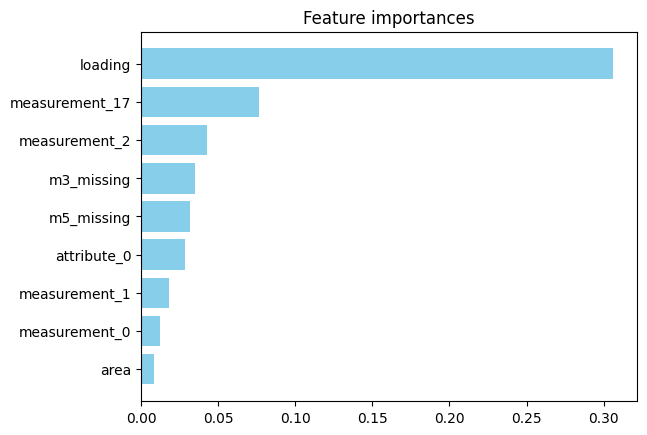

AVG auc_score: 0.590717863515232
FOLD 1 auc_score: 0.585
FOLD 2 auc_score: 0.595
FOLD 3 auc_score: 0.598
FOLD 4 auc_score: 0.583
FOLD 5 auc_score: 0.591


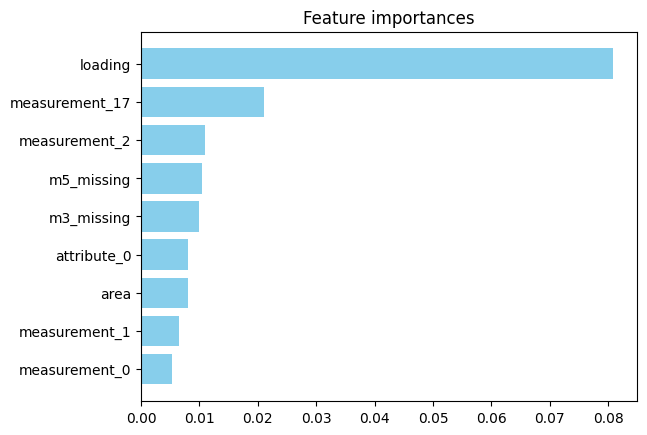

AVG auc_score: 0.5904852175385921
FOLD 1 auc_score: 0.585
FOLD 2 auc_score: 0.593
FOLD 3 auc_score: 0.595
FOLD 4 auc_score: 0.585
FOLD 5 auc_score: 0.589


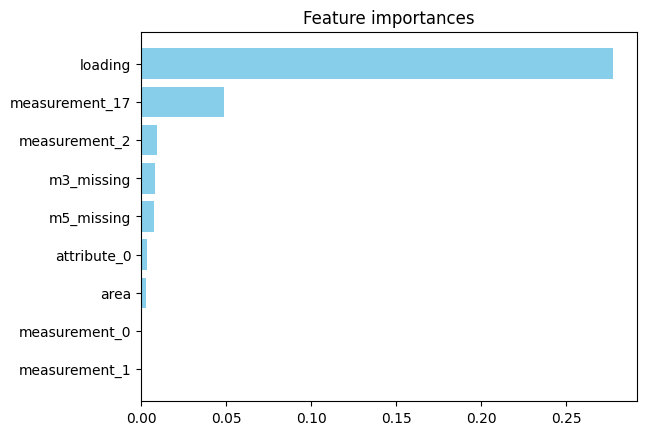

AVG auc_score: 0.5892798541202214
FOLD 1 auc_score: 0.585
FOLD 2 auc_score: 0.593
FOLD 3 auc_score: 0.597
FOLD 4 auc_score: 0.584
FOLD 5 auc_score: 0.589


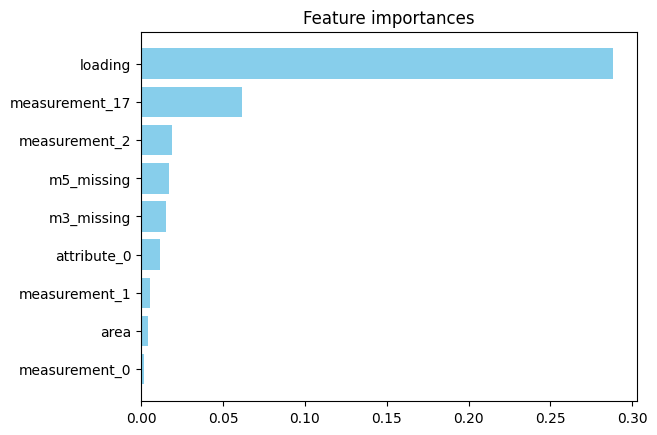

AVG auc_score: 0.5898104035678916
FOLD 1 auc_score: 0.586
FOLD 2 auc_score: 0.596
FOLD 3 auc_score: 0.599
FOLD 4 auc_score: 0.583
FOLD 5 auc_score: 0.590


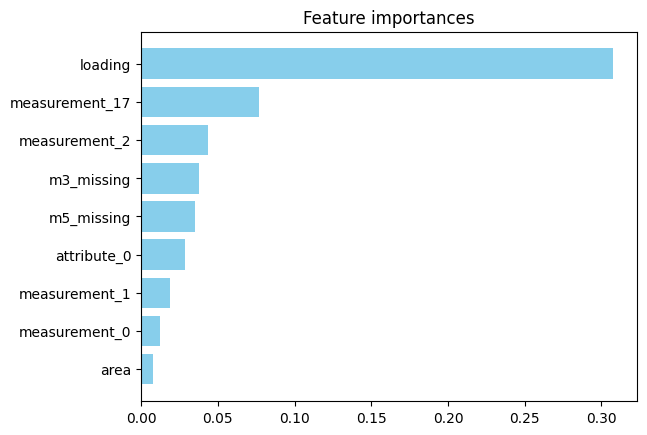

AVG auc_score: 0.5907710061074746


In [250]:
# Ensemble * 5

model_1 = LogisticRegression(max_iter=200, C=0.05, penalty="l1", solver="liblinear")
model_2 = LogisticRegression(max_iter=500, C=0.0001, penalty="l2", solver="newton-cg")
model_3 = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.8,
    C=0.007,
    tol=1e-2,
    solver="saga",
    max_iter=3000,
    random_state=27,
)
model_4 = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.8,
    C=0.01,
    tol=5e-2,
    solver="saga",
    max_iter=3000,
    random_state=27,
)
model_5 = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.8,
    C=0.05,
    tol=5e-2,
    solver="saga",
    max_iter=3000,
    random_state=27,
)

result = np.zeros(len(test))

for i, model in enumerate([model_1, model_2, model_3, model_4, model_5]):
    result += regression(model, feature_used, i) / 5
    # store the model
    with open(f"model_{i+1}.pkl", "wb") as f:
        pickle.dump(model, f)

### Submission Section

In [251]:
submission = pd.read_csv("train/sample_submission.csv")

submission["failure"] = result
submission.to_csv("submission.csv", index=False)